# Feature Engineering and Final Model

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [2]:
final_df = pd.read_pickle('beer_df.pkl')

In [3]:
final_df.skew(axis=0)

Av Score         -2.456780
Reviews           1.139846
Want              4.267093
Alc Percentage    1.339263
Year-round        0.295267
Brewery Beer      1.626660
dtype: float64

### Log the columns that are skewed

In [4]:
column = ['Reviews', 'Want', 'Alc Percentage']

final_df[column] = np.log(final_df[column])

In [5]:
final_df.skew(axis=0)

Av Score         -2.456780
Reviews          -0.631929
Want              0.267055
Alc Percentage    0.237599
Year-round        0.295267
Brewery Beer      1.626660
dtype: float64

## Cross Validation

In [6]:
Features = final_df.loc[:, ['Reviews', 'Want', 'Alc Percentage', 
                            'Year-round',  'Brewery Beer']]
Target = final_df['Av Score']

In [7]:
Features, Features_test, Target, Target_test = train_test_split(Features, Target, test_size=.2, random_state=10) 

Features, Target = np.array(Features), np.array(Target)

In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state = 20)
cv_lm_r2s, cv_lm_reg_r2s, cv_lasso, cv_poly, cv_l, cv_ridge, cv_lin, cv_poly2 = [], [], [], [], [], [], [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(Features, Target):
    
    Features_train, Target_train = Features[train_ind], Target[train_ind]
    Features_val, Target_val = Features[val_ind], Target[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()

    lm.fit(Features_train, Target_train)
    cv_lm_r2s.append(lm.score(Features_val, Target_val))
    cv_lin.append(lm.score(Features_train, Target_train))
    
    #scaler
    scaler = StandardScaler()
    Features_train_scaled = scaler.fit_transform(Features_train)
    Features_val_scaled = scaler.transform(Features_val)
    
    #ridge with feature scaling
    lm_reg = Ridge(alpha=1)
    lm_reg.fit(Features_train_scaled, Target_train)
    cv_lm_reg_r2s.append(lm_reg.score(Features_val_scaled, Target_val))
    cv_ridge.append(lm_reg.score(Features_train_scaled, Target_train))

    #lasso transformation
    lr_lasso = Lasso(alpha=.01)
    lr_lasso.fit(Features_train_scaled, Target_train)
    cv_lasso.append(lr_lasso.score(Features_val_scaled, Target_val))
    cv_l.append(lr_lasso.score(Features_train_scaled, Target_train))
    
    #polynomial transformation
    poly = PolynomialFeatures(degree=2) 

    Features_train_poly = poly.fit_transform(Features_train)
    Features_val_poly = poly.transform(Features_val)

    lm_poly = LinearRegression()
    lm_poly.fit(Features_train_poly, Target_train)
    cv_poly.append(lm_poly.score(Features_val_poly, Target_val))
    cv_poly2.append(lm_poly.score(Features_train_poly, Target_train))

In [9]:
print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s)
print('Lasso scores: ', cv_lasso)
print('Poly scores: ', cv_poly, '\n')
print('Linear val scores',cv_lin)
print('Ridge val scores',cv_ridge)
print('Lasso val scores',cv_l)
print('Poly val scores',cv_poly2, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')
print(f'Lasso mean cv r^2: {np.mean(cv_lasso):.3f} +- {np.std(cv_lasso):.3f}')
print(f'Poly mean cv r^2: {np.mean(cv_poly):.3f} +- {np.std(cv_poly):.3f}')

Simple regression scores:  [0.6576239498354466, 0.622355568593551, 0.6037401023071909, 0.5340132764241619, 0.7998626976044075]
Ridge scores:  [0.6586536510941636, 0.6218386179801636, 0.603949412526613, 0.5337845030800097, 0.8002020414447276]
Lasso scores:  [0.6653888595353363, 0.605953053738669, 0.6057741466515982, 0.5274959757571847, 0.804420590178154]
Poly scores:  [0.8224728892824841, 0.829804797775697, 0.8046950831806531, 0.7760245396319267, 0.807344721520422] 

Linear val scores [0.6383925242040409, 0.6464823987333619, 0.6528050740101244, 0.6775135623048405, 0.6129094867742532]
Ridge val scores [0.638383228458517, 0.646472133545949, 0.6527959428848309, 0.6775036014274569, 0.6129006912714908]
Lasso val scores [0.6342942875979954, 0.6413945821618434, 0.6489478662253, 0.6717900260094858, 0.6087354472816839]
Poly val scores [0.8258598442468418, 0.8237130324751536, 0.8319155144643626, 0.8407374563885153, 0.8258936827919556] 

Simple mean cv r^2: 0.644 +- 0.088
Ridge mean cv r^2: 0.644 

### Final R2 score

In [10]:
lm.fit(Features, Target)
lm.score(Features_test, Target_test)

0.61917984585388

### RMSE Score

In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt

target_pred = lm.predict(Features_test)
rms = sqrt(mean_squared_error(Target_test, target_pred))
rms

0.25289125382775124

### Coefficients

In [12]:
lm.coef_

array([-1.71652744e-01,  1.80345749e-01,  2.37133321e-01,  4.59705711e-02,
        1.82671814e-04])

### Scaled Coefficients

In [13]:
Features_scaled = scaler.fit_transform(Features)
Features_test_scaled = scaler.transform(Features_test)

In [14]:
lm.fit(Features_scaled, Target)
lm.coef_

array([-0.21440636,  0.19606626,  0.07784963,  0.02276307,  0.01947942])

### Linear Regression Assumptions

In [15]:
Features = final_df.loc[:, ['Reviews', 'Want', 'Alc Percentage', 'Year-round',  'Brewery Beer']]
Target = final_df['Av Score']

In [16]:
lr3 = LinearRegression()
fit3 = lr3.fit(Features, Target)

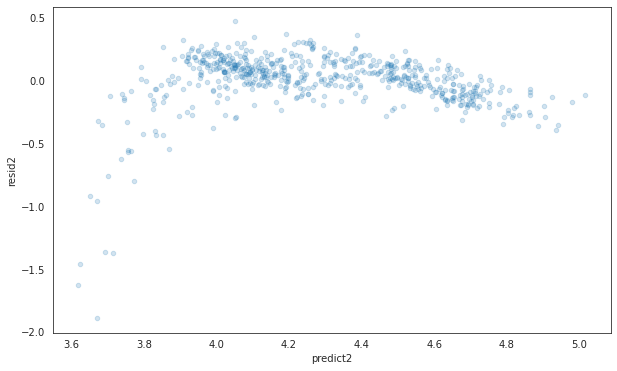

In [17]:
final_df['predict2']=fit3.predict(Features)
final_df['resid2']=final_df['Av Score']-final_df.predict2
with sns.axes_style('white'):
    plot=final_df.plot(kind='scatter',
                  x='predict2',y='resid2',alpha=0.2,figsize=(10,6))

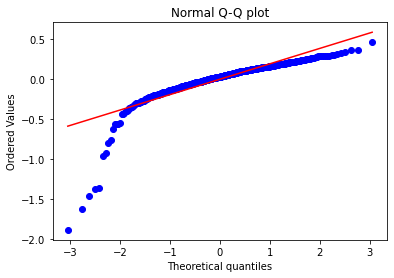

In [18]:
import scipy.stats as stats
stats.probplot(final_df['resid2'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()